**Purpose**

The goal of this code is to impute values for the PCIAT variables and, based on these, compute sii scores.

This code would not be part of what we submit to the Kaggle competition, since we wouldn't have access to the outcome variables there

**NOTE**

After getting the code working, we should simply replace the old PCIAT-PCIAT_Total and sii values with the imputed ones(?)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.impute import KNNImputer

In [3]:
#This is the starting data.
train_cleaned=pd.read_csv('train_cleaned.csv')

**Removing Participants with No Data**

Many participants don't have data for any of the 20 PCIAT variables. We'll remove these from the data file.

In [4]:
#First we'll create a list of columns that hold the PCIAT values
pciats = [col for col in train_cleaned.columns if 'PCIAT' in col]
pciats.remove('PCIAT-Season')
pciats.remove('PCIAT-PCIAT_Total')

#Remove rows where all values in pciats are NaN
train_imp_KNN = train_cleaned.copy()
train_imp_KNN['pciatsnotna_sum'] = train_imp_KNN[pciats].notna().sum(axis=1)
train_imp_KNN = train_imp_KNN[train_imp_KNN['pciatsnotna_sum'] != 0]
train_imp_KNN.reset_index(drop=True, inplace=True)

#Remove the pciatsnotna_sum variable
train_imp_KNN.drop(columns=['pciatsnotna_sum'], inplace=True)

**Imputing Missing Values**

Next we'll use KNN to impute the missing values.

In [ ]:
# Count the number of NaN values
print(train_imp_KNN[pciats].isnull().sum().sum())

#Identify the rows with at least one NaN value
train_imp_KNN['nan_rows'] = train_imp_KNN[pciats].isnull().any(axis=1)

88


In [8]:
# Create a copy of train_imp_KNN
train_imp_KNN2 = train_imp_KNN.copy()

In [9]:
# define imputer
Number_Neighbors=5
imputer = KNNImputer(n_neighbors=Number_Neighbors, weights='uniform', metric='nan_euclidean')

#The imputer.fit_transform function outputs a numpy array. So first I do the fitting, then convert the output back to a pandas dataframe.

imputations=imputer.fit_transform(train_imp_KNN[pciats])
df2 = pd.DataFrame(imputations, columns=pciats)

#Next take the result and insert into the original dataframe. 

train_imp_KNN[pciats]=train_imp_KNN[pciats].fillna(df2[pciats])

**Computing PCIAT_Total**

We can now recompute PCIAT_Total based on the imputed values

In [10]:
#Recalculate the PCIAT total score.
train_imp_KNN['PCIAT_Total_Imputed'] = train_imp_KNN[pciats].sum(axis=1)

**Computing sii Values**

The sii values are based on cutpoints; we can (re)compute these from the new PCIAT_Total values

In [11]:
#Now we can calculate a new sii score with the imputed values. 
bins = [0, 30, 49,79,100]
labels = [0,1,2,3]
train_imp_KNN['sii_imputed'] = pd.cut(train_imp_KNN['PCIAT_Total_Imputed'], bins=bins, labels=labels, right=False)

**Checking the Results**

Doing a quick check. The PCIAT_Total_Imputed values should all be larger than the PCIAT-PCIAT_Total values.

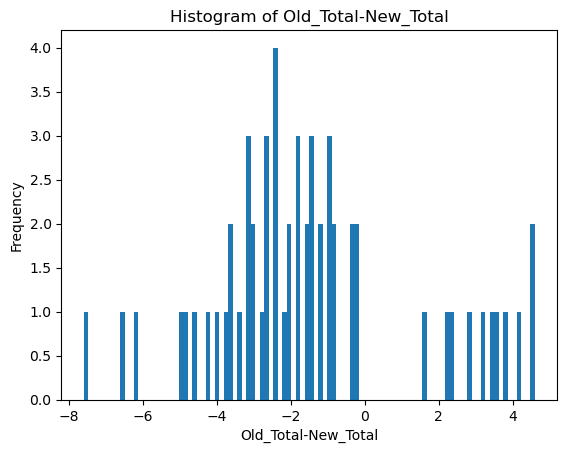

In [12]:
#Create a new variable by subtracting PCIAT-PCIAT_Total-PCIAT_Total
train_imp_KNN['Old_Total-New_Total'] = train_imp_KNN['PCIAT-PCIAT_Total'] - train_imp_KNN['PCIAT_Total_Imputed']

#Replace zeroes of PCIAT-PCIAT_Total-PCIAT_Total with NaN
train_imp_KNN['Old_Total-New_Total'] = train_imp_KNN['Old_Total-New_Total'].replace(0, np.nan)

#Create a histogram of PCIAT-PCIAT_Total-PCIAT_Total
plt.hist(train_imp_KNN['Old_Total-New_Total'], bins=100)
plt.title('Histogram of Old_Total-New_Total')
plt.xlabel('Old_Total-New_Total')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Identify the rows in train_imp_KNN where Old_Total-New_Total is positive
train_imp_KNN['Old_Total-New_Total_Positive'] = train_imp_KNN['Old_Total-New_Total'] > 0

In [16]:
# Make a list of rows in train_imp_KNN where Old_Total-New_Total_Positive is true
badrows = train_imp_KNN[train_imp_KNN['Old_Total-New_Total_Positive'] == True].index.tolist()

In [17]:
badrows

[213, 338, 355, 715, 721, 918, 971, 1252, 1578, 1682, 2185]

In [ ]:
#Create a new dataframe from train_imp_KNN2 that only includes the rows in badrows
train_imp_KNN2_bad = train_imp_KNN2.loc[badrows]
train_imp_KNN_bad = train_imp_KNN.loc[badrows]

#Export train_imp_KNN2_bad to a csv
train_imp_KNN2_bad.to_csv('train_imp_KNN2_bad.csv', index=False)
train_imp_KNN_bad.to_csv('train_imp_KNN_bad.csv', index=False)

**Output to CSV**

Finally, we'll output to a CSV for future experimentation

In [29]:
#train_imp_KNN.to_csv('train_imp_KNN.csv', index=False)